In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
NWS = nx.newman_watts_strogatz_graph(20000, 1000, 0.67, seed=42)
new_nodes = {e: n for n, e in enumerate(NWS.nodes, start=1)}
new_edges = [(new_nodes[e1], new_nodes[e2]) for e1, e2 in NWS.edges]
edgelist = []
for i in range(len(new_edges)):
    temp = [str(new_edges[i][0]), str(new_edges[i][1])]
    edgelist.append(temp)
G = nn.NNetwork()
G.add_edges(edgelist)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20000
num edges in G 33404370


num of subgraphs induced on k-paths: 1600
X.shape (2500, 1600)


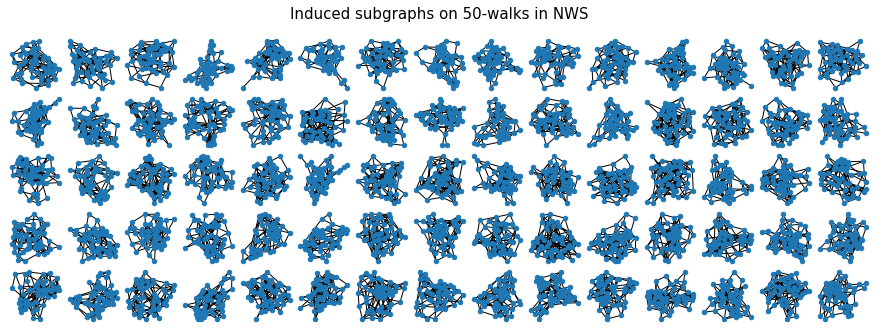

In [3]:
sampling_alg = 'pivot'

ntwk = 'NWS' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

X, embs = G.get_patches(k=k, sample_size=1600, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 1600


In [35]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 0.5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,False
1596,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1598,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [36]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.490625


In [37]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [38]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  3%|█▏                                         | 7/250 [00:00<00:03, 63.19it/s]

iteration 0, reconstruction error 264795.012099
iteration 10, reconstruction error 174753.125300


 11%|████▋                                     | 28/250 [00:00<00:03, 65.52it/s]

iteration 20, reconstruction error 173760.434112
iteration 30, reconstruction error 169190.838216


 20%|████████▍                                 | 50/250 [00:00<00:02, 67.88it/s]

iteration 40, reconstruction error 161200.544818
iteration 50, reconstruction error 158377.491561


 28%|███████████▉                              | 71/250 [00:01<00:02, 65.42it/s]

iteration 60, reconstruction error 157288.114280
iteration 70, reconstruction error 156730.012898


 37%|███████████████▍                          | 92/250 [00:01<00:02, 64.83it/s]

iteration 80, reconstruction error 156401.960560
iteration 90, reconstruction error 156188.452301


 46%|██████████████████▋                      | 114/250 [00:01<00:02, 65.98it/s]

iteration 100, reconstruction error 156034.269072
iteration 110, reconstruction error 155913.220484


 51%|████████████████████▉                    | 128/250 [00:01<00:01, 66.36it/s]

iteration 120, reconstruction error 155813.525634
iteration 130, reconstruction error 155728.422519


 60%|████████████████████████▊                | 151/250 [00:02<00:01, 68.84it/s]

iteration 140, reconstruction error 155653.251853
iteration 150, reconstruction error 155584.889543


 69%|████████████████████████████▏            | 172/250 [00:02<00:01, 66.51it/s]

iteration 160, reconstruction error 155521.755631
iteration 170, reconstruction error 155462.474502


 74%|██████████████████████████████▌          | 186/250 [00:02<00:01, 59.00it/s]

iteration 180, reconstruction error 155406.467846
iteration 190, reconstruction error 155353.356709


 84%|██████████████████████████████████▎      | 209/250 [00:03<00:00, 64.96it/s]

iteration 200, reconstruction error 155303.289475
iteration 210, reconstruction error 155256.387516


 92%|█████████████████████████████████████▋   | 230/250 [00:03<00:00, 64.29it/s]

iteration 220, reconstruction error 155212.977695
iteration 230, reconstruction error 155172.967510


100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 65.66it/s]


iteration 240, reconstruction error 155136.242530


###########################
Shape of W_true: (2500, 9)
###########################




  0%|                                                   | 0/250 [00:00<?, ?it/s]

iteration 0, reconstruction error 269640.945620


  5%|██▏                                       | 13/250 [00:00<00:03, 63.26it/s]

iteration 10, reconstruction error 177151.944547


  8%|███▎                                      | 20/250 [00:00<00:03, 63.57it/s]

iteration 20, reconstruction error 176340.828717


 14%|█████▋                                    | 34/250 [00:00<00:03, 62.95it/s]

iteration 30, reconstruction error 172687.488137


 16%|██████▉                                   | 41/250 [00:00<00:03, 63.14it/s]

iteration 40, reconstruction error 164445.638468


 20%|████████▏                                 | 49/250 [00:00<00:03, 64.58it/s]

iteration 50, reconstruction error 161035.832446


 25%|██████████▌                               | 63/250 [00:00<00:02, 63.86it/s]

iteration 60, reconstruction error 159899.565897


 28%|███████████▊                              | 70/250 [00:01<00:02, 65.13it/s]

iteration 70, reconstruction error 159267.838981


 34%|██████████████                            | 84/250 [00:01<00:02, 64.79it/s]

iteration 80, reconstruction error 158870.796029


 36%|███████████████▎                          | 91/250 [00:01<00:02, 64.90it/s]

iteration 90, reconstruction error 158596.331237


 45%|██████████████████▎                      | 112/250 [00:01<00:02, 60.89it/s]

iteration 100, reconstruction error 158389.746714
iteration 110, reconstruction error 158224.075811


 53%|█████████████████████▊                   | 133/250 [00:02<00:01, 61.81it/s]

iteration 120, reconstruction error 158086.190492
iteration 130, reconstruction error 157968.161441


 62%|█████████████████████████▎               | 154/250 [00:02<00:01, 63.71it/s]

iteration 140, reconstruction error 157865.478427
iteration 150, reconstruction error 157775.816027


 67%|███████████████████████████▌             | 168/250 [00:02<00:01, 65.74it/s]

iteration 160, reconstruction error 157696.771912
iteration 170, reconstruction error 157626.905633


 76%|██████████████████████████████▉          | 189/250 [00:02<00:00, 65.04it/s]

iteration 180, reconstruction error 157565.164646
iteration 190, reconstruction error 157510.878154


 84%|██████████████████████████████████▍      | 210/250 [00:03<00:00, 65.44it/s]

iteration 200, reconstruction error 157463.519166
iteration 210, reconstruction error 157422.752605


 92%|█████████████████████████████████████▉   | 231/250 [00:03<00:00, 65.18it/s]

iteration 220, reconstruction error 157387.709539
iteration 230, reconstruction error 157357.846452


100%|█████████████████████████████████████████| 250/250 [00:03<00:00, 63.47it/s]

iteration 240, reconstruction error 157332.463267


###########################
Shape of W_false: (2500, 9)
###########################




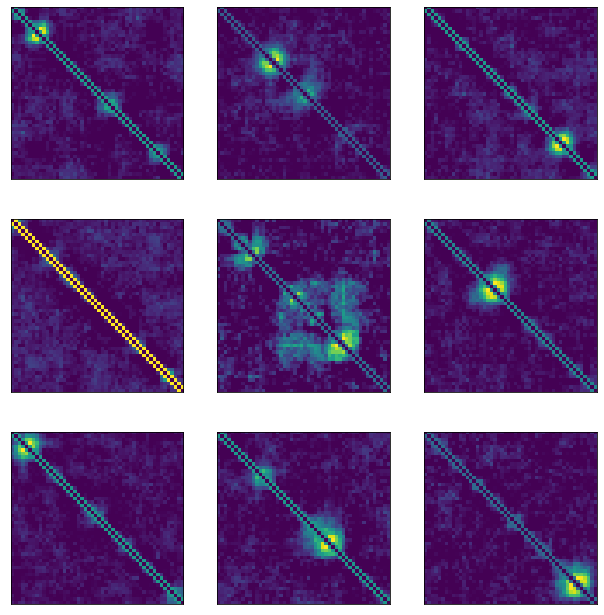

In [39]:
display_dictionary(W = W_true,
                   figsize = [10,10])

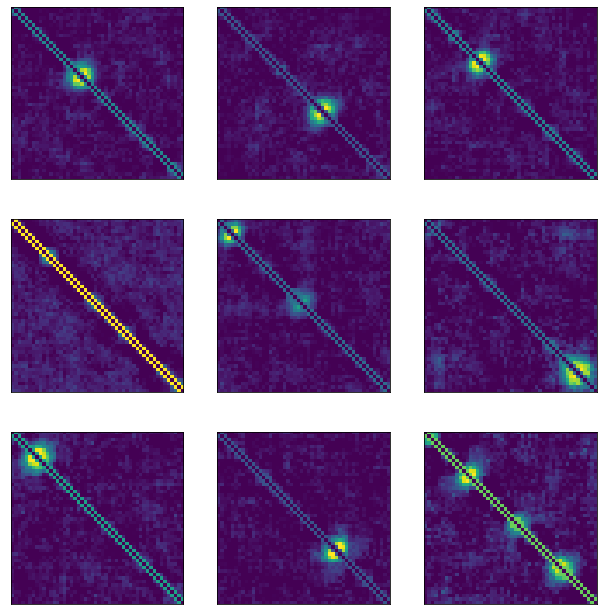

In [40]:
display_dictionary(W = W_false,
                   figsize = [10,10])

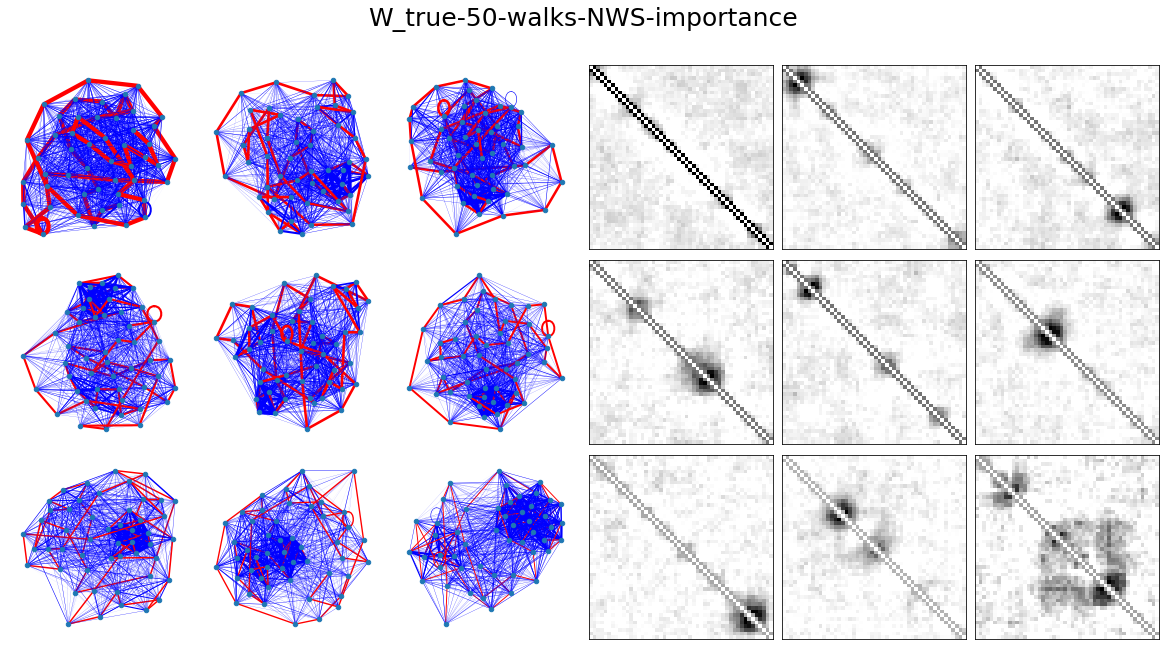

In [41]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

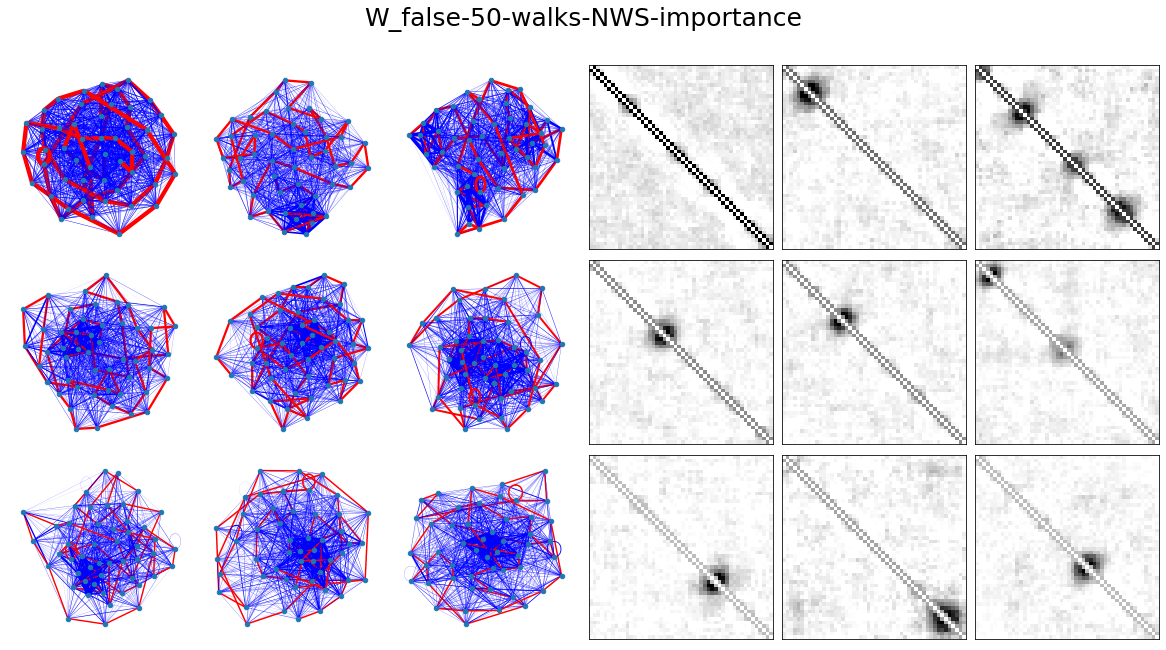

In [42]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [43]:
true_norm = np.linalg.norm(W_true.T, ord=1, axis=1)
false_norm = np.linalg.norm(W_false.T, ord=1, axis=1)

data_arr = np.stack((true_norm, false_norm), axis=0).T
df_boxplot = pd.DataFrame(data_arr, columns = ['Synchronizing','Non-Synchronizing'])
df_boxplot

,Synchronizing,Non-Synchronizing
0,8.287973,7.509307
1,7.202062,6.937888
2,8.625000,7.554022
3,10.675604,10.861701
4,7.874960,7.865972
5,7.193980,7.140658
6,8.047420,7.320778
7,7.921587,6.281947
8,6.562338,8.924399


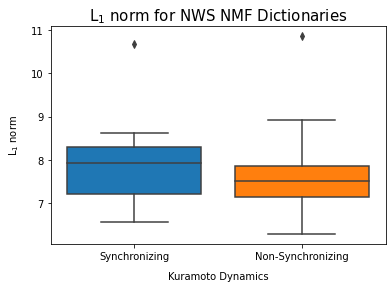

In [45]:
ax = sns.boxplot(data=df_boxplot, saturation=1)
ax.axes.set_title("L$_1$ norm for NWS NMF Dictionaries", fontsize=15)
plt.xlabel("Kuramoto Dynamics", labelpad=10)
plt.ylabel("L$_1$ norm", labelpad=10);